In [1]:
from lvmtipo.actors import lvm
from lvmagp.focus import Focus

In [2]:
await lvm.sci.start()
await lvm.sci.pwi.setConnected(True)
await lvm.sci.foc.moveToHome()

focus = Focus(lvm.sci)

In [3]:
rc = await lvm.sci.foc.moveToHome()
pos = rc.unpack('Position')
print(f"Home:        {pos}")

print(f"Nominal:     {(await focus.nominal(10.)).unpack('Position')}")
print(f"Offset -0.1: {(await focus.offset(-0.1)).unpack('Position')}")
print(f"Position 42: {(await focus.position(42)).unpack('Position')}")

Home:        40.0
Nominal:     36.074
Offset -0.1: 35.974000000000004
Position 42: 42.0


In [4]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
from matplotlib.patches import Ellipse, Rectangle
from matplotlib import colors


from mpl_toolkits.axes_grid1 import make_axes_locatable


from astropy.visualization import astropy_mpl_style
#plt.style.use(astropy_mpl_style)


ellipse = lambda c: Ellipse(xy=(c['x'], c['y']),
                            width=8*c['a'],
                            height=8*c['b'],
                            angle=c['theta'] * -180. / np.pi)

def plot_catalog(ax, catalog, color="red", cat_max=8, cat_rest=None):
     for c in catalog[:cat_max]:
         e = ellipse(c)
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)
     if cat_rest:
         for c in catalog[cat_max+1:]:
             e = ellipse(c)
             e.set_facecolor('none')
             e.set_edgecolor("white")
             ax.add_artist(e)

def plot_centroid(ax, catalog, color="white"):
     catalog = catalog.transpose()
     for c in catalog:
         e = ellipse({'x': c[0], 'y': c[1], 'a': 8, 'b': 8, 'theta': 0})
         e.set_facecolor('none')
         e.set_edgecolor(color)
         ax.add_artist(e)

def plot_images(images, vmin=None, vmax=None, rotate=None, cat_max = 8, cat_rest = None, cat_extra=None, figsize=None, wcs=None):
    data = images[0].data
    mean, sigma, min, max = np.mean(data), np.std(data), np.min(data), np.max(data)
    lperc, uperc = np.percentile(data, 5), np.percentile(data, 99.5)
    median = np.median(data)

    
    args={}
#    fig, ax = plt.subplots(1, ncols=(len(images)))
#    fig, ax = plt.subplots(1, ncols=(len(images)), dpi=100)
    fig, ax = plt.subplots(1, ncols=(len(images)), figsize=figsize if figsize else (8, 5/len(images)), *args)
#    fig, ax = plt.subplots(nrows=(len(images)), figsize=(16,9))
    
    fig.canvas.toolbar_visible = 'fade-in-fade-out'
#    fig.canvas.footer_visible = False
    fig.canvas.header_visible = False
    fig.canvas.toolbar_position = 'left'
    is_single_image = len(images) > 1


    for idx, img in enumerate(images):
        if rotate and rotate[idx]:
            data = np.copy(img.data).transpose()
        else:
            data = img.data

        ax_idx = ax[idx] if is_single_image else ax
        ax_idx.set_title(img.header["CAMNAME"])
        ax_idx.scatter([img.data.shape[1]/2], [img.data.shape[0]/2], marker='+', s=40, color='red')
#        ax_im = ax_idx.imshow(data,
#                              vmin=vmin if vmin else median,
#                              vmax=vmax if vmax else uperc)
        if wcs: 
            # wcs = WCS(hdu.header)
            print(wcs)

        ax_im = ax_idx.imshow(data,
                              norm=PowerNorm(1.4,
                                             vmin=vmin if vmin else median,
                                             vmax=vmax if vmax else uperc,
                                             clip=True,
                                            )
                             )

        

        ax_idx.invert_yaxis()
        fig.colorbar(ax_im, cax=make_axes_locatable(ax_idx).append_axes('right', size='3%', pad=0.05), orientation='vertical')
      
        if img.catalog:
            plot_catalog(ax_idx, img.catalog, "red", cat_max, cat_rest)

        if cat_extra:
            plot_catalog(ax_idx, cat_extra[idx], "yellow")

        if hasattr(img, "centroid"):
            plot_centroid(ax_idx, img.centroid, "white")

    # plt.scatter(x, y, marker='+', s=40, color='red')

    fig.tight_layout()
    plt.show()

        x                  y                 peak              flux               fwhm            ellipticity    
------------------ ------------------ ----------------- ------------------ ------------------ -------------------
15.466705516891212 294.19958016002994 816.7350463867188 17220.345934448243 3.4879325764267923 0.05762025287156247
None
 x   y  peak flux fwhm ellipticity
--- --- ---- ---- ---- -----------
None
cam: east focus: 42.2 srcs: 1
cam: center focus: 42.2 srcs: 0


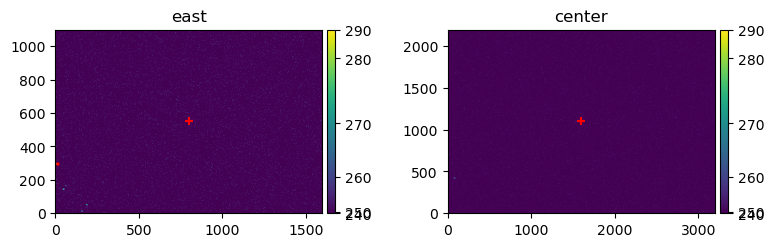

        x                 y                 peak               flux               fwhm            ellipticity     
----------------- ------------------ ------------------ ------------------ ------------------ --------------------
15.29360068464278 294.08376509606495 497.59674072265625 17017.685396728517 3.8590454291922374 0.006054836341230829
None
 x   y  peak flux fwhm ellipticity
--- --- ---- ---- ---- -----------
None
cam: east focus: 42.9 srcs: 1
cam: center focus: 42.9 srcs: 0


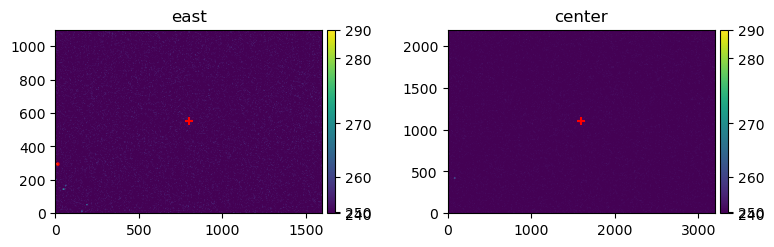

 x   y  peak flux fwhm ellipticity
--- --- ---- ---- ---- -----------
None
 x   y  peak flux fwhm ellipticity
--- --- ---- ---- ---- -----------
None
cam: east focus: 43.6 srcs: 0
cam: center focus: 43.6 srcs: 0


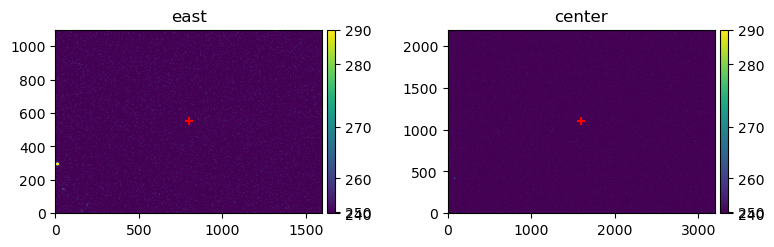

        x                  y                 peak               flux              fwhm            ellipticity     
------------------ ------------------ ------------------ ----------------- ------------------ --------------------
381.25922596933293 244.07875680441583 1651.1707763671875 2338531.737357176 31.376616579241382 0.020931462993983185
None
        x                 y                 peak              flux               fwhm            ellipticity    
----------------- ------------------ ----------------- ------------------ ------------------ -------------------
625.0575182508101 121.19839277046988 223.9393310546875 288429.91735961917 11.525667327882275 0.09415565040980645
None
cam: east focus: 39.4 srcs: 1
cam: center focus: 39.4 srcs: 1


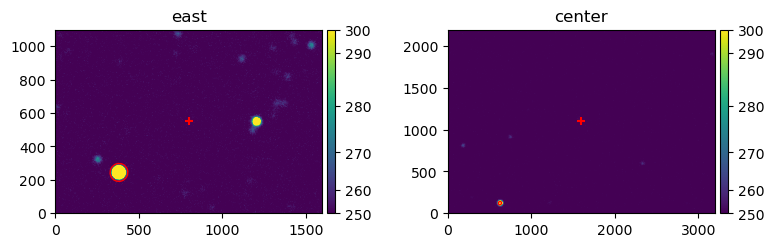

        x                  y                peak              flux               fwhm             ellipticity     
------------------ ------------------ ---------------- ------------------ ------------------ ---------------------
 324.3156083483622 186.80274716060907 7635.18701171875   2474623.90326172  16.31299083440327 0.0012165644275597964
1148.0911658907858 491.47529156328477  690.93115234375 208718.42034606938 12.552029477054077  0.019654869829438648
None
 x   y  peak flux fwhm ellipticity
--- --- ---- ---- ---- -----------
None
cam: east focus: 40.1 srcs: 2
cam: center focus: 40.1 srcs: 0


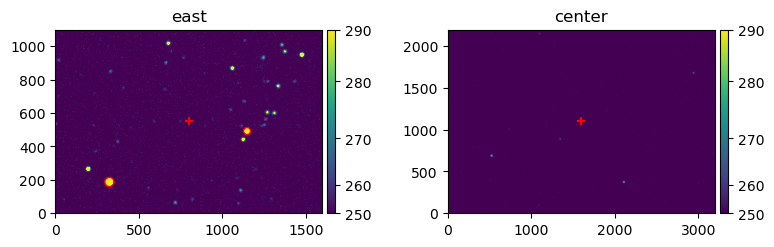

        x                  y                 peak               flux               fwhm            ellipticity     
------------------ ------------------ ------------------ ------------------ ------------------ --------------------
315.19596594381005  177.6809121318846      41512.2421875 2473133.9440777577    7.3637314763727 0.001602715001345345
1139.0565053784344 482.36165586064084   3576.65283203125 210848.46540161132  6.853618933913748 0.013883453056330763
1465.6570393200655  937.7526483986724   714.152587890625  42615.30395812989  5.601572771700918 0.016591406157356325
190.12383129322376  255.0746439078372  674.5967407226562 41727.565402832035 5.5578519185384225 0.020823240533895504
1050.5741730575674  857.5435997262505 437.44415283203125  26244.61294250489  4.763238918192332   0.0431555946062514
 1115.565613926408  431.1946462091399    411.23974609375 24568.866756591808  4.639608056455833  0.06665329618469573
 668.3590683357892  1006.409741543529  430.2167053222656 23909.693865356

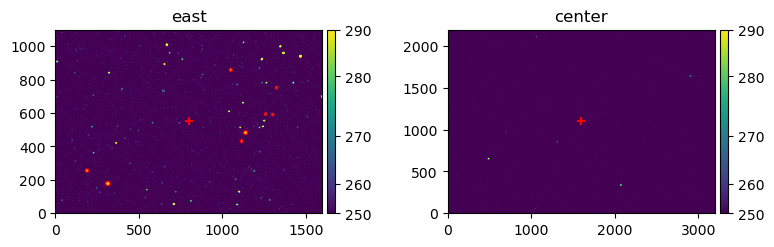

        x                  y                 peak               flux               fwhm            ellipticity     
------------------ ------------------ ------------------ ------------------ ------------------ --------------------
 309.1405666482348 171.69212649954773     63317.48828125  1701445.277163697  5.466577475905696 0.007433576016753762
1133.0613877012445  476.4382588503843    8993.1357421875  212080.6093286133  4.625314969796523 0.020869338864423548
1459.6712314739573  931.8065670837344    1805.9912109375  43030.52406250001  4.207207611891567  0.02467660759040846
184.10610432401208  249.0841455253356   1878.70166015625  41527.37760375977  4.186022231220656 0.024135309805923266
1044.4929275585453  851.5717980075725 1087.8543701171875 26343.316529541018  3.988205051300929 0.004300658085250597
1109.5834747349631  425.3272275610622 1018.1463623046875  24274.72816711426 3.9180820788726125 0.023364344352612365
 662.2216109110501  1000.422972086552  966.8588256835938 23505.105133056

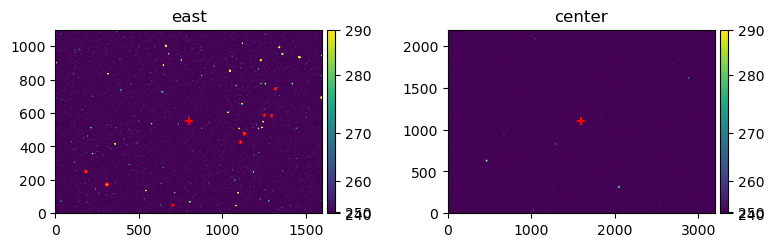

[WARNING]: Covariance of the parameters could not be estimated (OptimizeWarning)


[[43.29190699         inf]
 [        nan         nan]]
[43.29190699         inf]


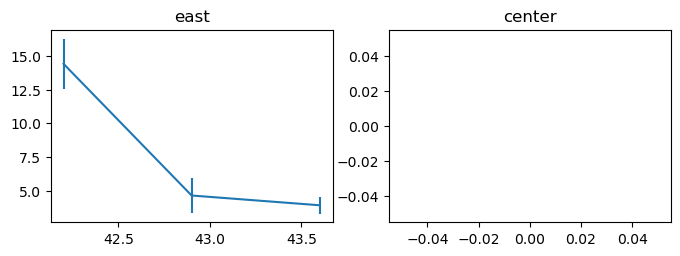

In [5]:
from lvmagp.focus.focusseries.base import FocusSeries
from lvmagp.focus.curvefit import fit_hyperbola
from lvmagp.images import Image

import matplotlib.pyplot as plt


def callback(data):
    if isinstance(data[0], Image):
        for idx, img in enumerate(data):
            print(f"cam: {img.header['CAMNAME']} focus: {img.header['FOCUSDT']} srcs: {len(img.catalog)}")
        plot_images(data)
    elif isinstance(data[0], tuple):
        fig, ax = plt.subplots(1, ncols=(len(data)), figsize=(8, 5/len(data)))

        for idx, d in enumerate(data):
            camera = d[0]
            dd = d[1]
            focus = [d["focus"] for d in dd]
            r = [d["r"] for d in dd]
            rerr = [d["rerr"] for d in dd]

            ax_idx = ax[idx] if len(data) > 1 else ax
            ax_idx.set_title(camera)
            ax_idx.errorbar(focus, r, yerr=rerr)

    
focvals = await focus.fine(exposure_time=5.0, guess=41.5, count=3, step=0.7, callback=callback)
print(focvals)
print(np.nanmean(focvals, axis=0))
